# Playlist Generation

### Goal: 

- Step 1: Top tracks: From a seed song find all top tracks from all related artists
- Step 2: Similar songs: From a seed song find all songs from related artists, and filter by similar songs based on Spotify API audio features 
- Step 3: Simple sampling to find the best playlist
- Step 4: Simulated Annealing to find the best playlist
- Step 5: Comparison and validation of methods

# Generate lists of candidate songs that fit into four buckets

**4 buckets of songs**

1. Top tracks from related artists
2. Tracks from related artists
3. Tracks from related artists identified as similar songs (using manhattan distance + Spotify API features)
3. Tracks from our database identified as similar (using raw audio  + vantage point method)

### Import Libraries and create spotify credentials manager

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
#importing module spotipy to make api calls to spotify
import spotipy
# module to extract song from url
import urllib
# OAuth Credenials
from spotipy.oauth2 import SpotifyClientCredentials
from multiprocessing import Process, Queue
import pandas as pd 
import numpy as np
from sklearn import datasets, linear_model
#from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
import math
client_credentials_manager = SpotifyClientCredentials(client_id='4a1a457d14c0445a96e7021a5523905b', client_secret='45b186d601544fdcbb4fe07c7b23cce5')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


### Read in csv that has the track ids from all Spotify playlists

In [134]:
track_info = pd.read_csv("kmeans_output.csv")
track_ids = list(track_info['id'])
print(len(track_ids), "example track ids", "\n")
print(track_ids[:15])
track_result = sp.tracks(["1tpShM80HMT9vKjRiA3EzW"])

14887 example track ids 

['1tPGSiwtvmMVAqmniJ7oHp', '1tpShM80HMT9vKjRiA3EzW', '1TPUbLdzpfgF7wrPEXIAAB', '1tQGRq2WOBXjL3JWdWMONg', '1TqmZVIyeD4aN4Wa0wbnfy', '1TquBahz02HCaxj8jy5tTo', '1Tr4K5MU5XYE44umXGDndd', '1tRlCCMVLSVQrrN9PPgtf0', '1TScJLsDWzDVBFpCU5vJDo', '1TSjS0q24cPW2S4pYj2wEK', '1Tt4sE4pXi57mTD1GCzsqm', '1TtdHZ4KvN56LCt9evBUaL', '1TTiZwoorWMR4KmaI0irjU', '1TtJJ7YP6JCQ3aH8PQpreD', '1TTOAw90zzNWKnUgzzcvZW']


### Input a seed track

In [137]:
seed_id = "7qiZfU4dY1lWllzX7mPBI3"
track_info = sp.tracks([seed_id])
name = track_info['tracks'][0]['name']
seed_preview_url = track_info['tracks'][0]['preview_url']
print("ID: ", seed_id, "\n \n Artist name: ",track_info['tracks'][0]['artists'][0]['name'], "\n Track name: ",name)

ID:  7qiZfU4dY1lWllzX7mPBI3 
 
 Artist name:  Ed Sheeran 
 Track name:  Shape of You


### Get the track's artists

In [139]:
artist_names = []
artist_ids = []
for each in track_info['tracks'][0]['artists']:
    artist_names.append(each['name'])
    artist_ids.append(each['id'])
print(artist_names)
print(artist_ids,"\n")
print(len(artist_names), "artist(s)")

[u'Ed Sheeran']
[u'6eUKZXaKkcviH0Ku9w2n3V'] 

1 artist(s)


### Get related artists

In [140]:
all_related_artists_names = []
all_related_artists_ids = []

for each in artist_ids:
    related = sp.artist_related_artists(each)
    for related_artist in related['artists']:
        all_related_artists_names.append(related_artist['name'])
        all_related_artists_ids.append(related_artist['id'])
all_related_artists_ids = np.array(all_related_artists_ids)
all_related_artists_ids_unique = np.unique(all_related_artists_ids)
print(len(all_related_artists_ids_unique), "related artists")

20 related artists


### Bucket #1: Top tracks from the related artists

In [141]:
top_tracks_related_artists = []
for each in all_related_artists_ids_unique:    
    top_tracks_one_artist = sp.artist_top_tracks(each)

    for each in top_tracks_one_artist['tracks']:
        song = each['id']
        top_tracks_related_artists.append(song)
        
print(len(top_tracks_related_artists),"top tracks from related artists")

200 top tracks from related artists


### Bucket #2: Songs from related artists that are not in top tracks but are similar

In [142]:
print("Finding albums from related artists...")
all_related_albums = []
for each in all_related_artists_ids_unique:    
    albums = sp.artist_albums(each, album_type=None, country=None, limit=50, offset=0)
    for each in albums['items']:
        album_id = each['id']
        all_related_albums.append(album_id)
sp.album_tracks(all_related_albums[1], limit=50, offset=0)
print("Finding songs from those albums...")

all_related_songs = []
all_related_preview_urls = []
for index, each_album in enumerate(all_related_albums):
    album_tracks = sp.album_tracks(each_album, limit=50, offset=0)
    if index%50==0: print(index)
    for each in album_tracks['items']:
        all_related_songs.append(each['id'])
        all_related_preview_urls.append(each['preview_url'])
all_related_songs = np.array(all_related_songs)
all_related_songs = list(np.unique(all_related_songs))
combined = [seed_id]
combined.extend(all_related_songs)
all_related_songs = combined
print(len(all_related_songs), " songs from related artists")

Finding albums from related artists...
Finding songs from those albums...
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
10262  songs from related artists


### Test to make sure the songs sound like they're from related artists

In [143]:
from IPython.core.display import HTML
link = '<a href=' + str(seed_preview_url) + '>preview input song</a>'
display(HTML(link))
link = '<a href=' + str(all_related_preview_urls[10]) + '>preview related song</a>'
display(HTML(link))

### Function to get Spotify API features given a list of track ids

In [144]:
def get_spotify_features(track_ids,numLoops=None):
    track_ids_all= []
    popularity = []
    preview_urls_all =[]
    artists_all = []
    names_all = []
    track_numbers_all = []
    num_markets = []
    
    # set parameters
    offset=0
    limit=50
    if numLoops==None: 
        numLoops=int(math.floor(len(track_ids)/50)+1)
    aud_features = np.empty((limit*numLoops, 13))
    for loopIndex in range(numLoops):
        start = offset + limit*loopIndex # start 
        tracks = track_ids[start:start+limit]
        try:
            tracks_list = sp.tracks(tracks)
            features = sp.audio_features(tracks=tracks)
        except:
            print("Couldn't get data", index)
            continue
        for index, track in enumerate(tracks_list['tracks']):
            
            try:
                if (start+index)%1000==0: 
                    print(index+1+start)
                preview_urls_all.append(track['preview_url'])
                track_ids_all.append(track['id'])
                popularity.append(track['popularity'])
                names_all.append(track['name'])
                artists_all.append(track['artists'][0]['name'])
                track_numbers_all.append(track['track_number'])
                num_markets.append(track['available_markets'])
                songData = features[index]
                aud_features[index+start][0] = songData['acousticness']
                aud_features[index+start][1] = songData['danceability']
                aud_features[index+start][2] = songData['energy']
                aud_features[index+start][3] = songData['instrumentalness']
                aud_features[index+start][4] = songData['key']
                aud_features[index+start][5] = songData['liveness']
                aud_features[index+start][6] = songData['loudness']
                aud_features[index+start][7] = songData['mode']
                aud_features[index+start][8] = songData['tempo']
                aud_features[index+start][9] = songData['time_signature']
                aud_features[index+start][10] = songData['valence']
                aud_features[index+start][11] = songData['duration_ms']
                aud_features[index+start][12] = songData['speechiness']
                 
            except:
                print("Some fields not available", index)

    aud_features = aud_features[:len(names_all),]
    track_data = pd.DataFrame({
    'preview_url': preview_urls_all,
    'id': track_ids_all,
    'popularity': popularity,
    'artists': artists_all,
    'names': names_all,
    'acousticness': aud_features[:,0],
    'danceability': aud_features[:,1],
    'energy': aud_features[:,2],
    'instrumentalness': aud_features[:,3],
    'key': aud_features[:,4],
    'liveness': aud_features[:,5],
    'loudness': aud_features[:,6],
    'mode': aud_features[:,7],
    'tempo': aud_features[:,8],
    'time_signature': aud_features[:,9],
    'valence': aud_features[:,10],
    'duration': aud_features[:,11],
    'speechiness': aud_features[:,12],
    'available_markets': num_markets
    
   
    })
    #q.put(track_data)
    print(len(num_markets), len(popularity), aud_features.shape)
    #name = multiprocessing.current_process().name
    print('Exiting')
    return track_data


### Get all Spotify features for Bucket 1

In [145]:
print(len(top_tracks_related_artists))
top_tracks_df = get_spotify_features(track_ids=top_tracks_related_artists) 

200
1
Couldn't get data 49
200 200 (200, 13)
Exiting


In [197]:
top_tracks_df.head()

,acousticness,artists,available_markets,danceability,duration,energy,id,instrumentalness,key,liveness,loudness,mode,names,popularity,preview_url,speechiness,tempo,time_signature,valence
0,0.583,Ellie Goulding,"[CA, MX, US]",0.430,240867.0,0.530,3odrUVQ9tvRpkC9II2oWzx,0.000000,1.0,0.1020,-7.941,1.0,"Still Falling For You - From ""Bridget Jones's ...",69,https://p.scdn.co/mp3-preview/9afcd95ec52726e1...,0.0447,96.140,4.0,0.166
1,0.240,Ellie Goulding,"[CA, MX, US]",0.254,252534.0,0.617,2l8w0zZVn4AZNuzrht7MRT,0.000000,5.0,0.1250,-6.612,0.0,"Love Me Like You Do - From ""Fifty Shades Of Grey""",72,https://p.scdn.co/mp3-preview/a4e18eb3de6b8e6b...,0.0537,189.425,4.0,0.271
2,0.296,Ellie Goulding,"[CA, MX, US]",0.516,231212.0,0.772,0xMd5bcWTbyXS7wPrBtZA6,0.000000,10.0,0.1010,-5.031,0.0,Burn,70,https://p.scdn.co/mp3-preview/b0b06f9ee468d539...,0.0476,87.038,4.0,0.319
3,0.227,Ellie Goulding,"[CA, MX, US]",0.510,154435.0,0.308,0ZPfDxZn5O0L84wvPSN2iG,0.000313,0.0,0.1200,-9.168,1.0,How Long Will I Love You - Bonus Track,67,https://p.scdn.co/mp3-preview/e206717cf7253882...,0.0321,126.349,5.0,0.146
4,0.279,Ellie Goulding,"[CA, MX, US]",0.697,213445.0,0.687,4nS1sut0R2mgmFitKIShVe,0.000005,2.0,0.0861,-6.574,0.0,On My Mind,69,https://p.scdn.co/mp3-preview/47fbaef17b5ca606...,0.0537,154.921,4.0,0.733


### Get Spotify API Features for Bucket 2

In [148]:
features_df = get_spotify_features(track_ids=all_related_songs)

1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
10262 10262 (10262, 13)
Exiting


In [149]:
features_df.head()

,acousticness,artists,available_markets,danceability,duration,energy,id,instrumentalness,key,liveness,loudness,mode,names,popularity,preview_url,speechiness,tempo,time_signature,valence
0,0.58100,Ed Sheeran,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.825,233713.0,0.652,7qiZfU4dY1lWllzX7mPBI3,0.00000,1.0,0.0931,-3.183,0.0,Shape of You,99,https://p.scdn.co/mp3-preview/84462d8e1e4d0f9e...,0.0802,95.977,4.0,0.933
1,0.13100,ZAYN,"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...",0.748,188491.0,0.627,000xQL6tZNLJzIrtIgxqSl,0.00000,7.0,0.0852,-6.029,1.0,Still Got Time,90,https://p.scdn.co/mp3-preview/2385471a5d35709a...,0.0644,120.963,4.0,0.513
2,0.44700,Emeli Sandé,"[CA, MX, US]",0.597,195427.0,0.543,001NMNauIqU8t70X48P8vX,0.00000,0.0,0.2750,-10.280,1.0,Babe,39,https://p.scdn.co/mp3-preview/9551e988f6521968...,0.3100,179.880,4.0,0.784
3,0.09170,Sia,[PL],0.633,217040.0,0.711,005Ua0AZQDAtOpavz5kdpW,0.00178,10.0,0.4770,-7.508,0.0,Move Your Body - Alan Walker Remix,15,https://p.scdn.co/mp3-preview/2e6451d064b9d6f7...,0.1090,128.012,4.0,0.375
4,0.00883,Sidonie,[ES],0.702,268947.0,0.824,006dQ6824YZgSvIvBRhcJT,0.00000,6.0,0.0766,-4.724,1.0,Carreteras Infinitas,22,https://p.scdn.co/mp3-preview/5527a471067cde16...,0.0343,104.004,4.0,0.785


## Find most similar songs acoustically

### Calculate the distance between the input song and related songs

In [150]:
from scipy.spatial.distance import cityblock
distance_features = features_df[['acousticness', 'danceability', 
                                 'duration', 'energy', 'instrumentalness', 'liveness', 
                                 'loudness', 'speechiness', 'tempo', 'valence']]
distance_features.head()

,acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.58100,0.825,233713.0,0.652,0.00000,0.0931,-3.183,0.0802,95.977,0.933
1,0.13100,0.748,188491.0,0.627,0.00000,0.0852,-6.029,0.0644,120.963,0.513
2,0.44700,0.597,195427.0,0.543,0.00000,0.2750,-10.280,0.3100,179.880,0.784
3,0.09170,0.633,217040.0,0.711,0.00178,0.4770,-7.508,0.1090,128.012,0.375
4,0.00883,0.702,268947.0,0.824,0.00000,0.0766,-4.724,0.0343,104.004,0.785


In [151]:
seed_features = distance_features.ix[0,]
related_features = distance_features.ix[1:,]
print(len(related_features))
sample_size = len(related_features)
distance_vector = np.empty((sample_size))
for index,row in related_features.iterrows():
    if index>sample_size-1: break
    #print(row)
    distance_vector[index]=cityblock(seed_features, row)
print(distance_vector.shape)
distance_vector[10015]

10261
(10261,)


7321.1311999999998

### Sort the distance output and find the 500 most acoustically similar songs

In [159]:
min_indices = distance_vector.argsort()[0:500:]
top_similarity_index = min_indices[2]
top_similarity_index
related_all_features_with_seed = features_df.ix[:]
seed_all_features = features_df.ix[0,]
link = '<a href=' + str(seed_all_features['preview_url']) + '>preview seed song</a>'
display(HTML(link))
for each in range(10):
    print(related_all_features_with_seed['artists'][min_indices[each]], related_all_features_with_seed['id'][min_indices[each]])
    link = '<a href=' + str(related_all_features_with_seed['preview_url'][min_indices[each]]) + '>preview related song #'+str(each)+ '</a>'
    display(HTML(link))

Ed Sheeran 7qiZfU4dY1lWllzX7mPBI3


Crowded House 6lLPLfz3R9LMxlLu5r1ms9


MØ 1FDRsQSUu2l88pCde68XxZ


Calvin Harris 2nPYML5WnGJBiOrBnMsjfp


Ellie Goulding 5EurZLrwTEL7eUVtr0zHiT


Ellie Goulding 6n7wUelYPaKsuL2HmrmlBY


Christine and the Queens 0cQXynqlLIPaY2GKV3y4SD


Solano 0TGtD6fbpp2MIzwFdtEyXx


All Saints 5dKpYLYmuN6t12ucMLvBJM


Daniel Powter 5SraAzB6oA1mwWj9vvNZG6


In [49]:
#features_df.to_csv('related_songs.csv', encoding='utf-8')

### Bucket 1: Top tracks from related artists

In [167]:
print(top_tracks_df.shape)
nona = top_tracks_df.dropna()
print(nona.shape)
bucket1 = nona['id'].values
bucket1[:5]

(200, 19)
(200, 19)


array([u'3odrUVQ9tvRpkC9II2oWzx', u'2l8w0zZVn4AZNuzrht7MRT',
       u'0xMd5bcWTbyXS7wPrBtZA6', u'0ZPfDxZn5O0L84wvPSN2iG',
       u'4nS1sut0R2mgmFitKIShVe'], dtype=object)

### Bucket 2: Any tracks from related artists

In [169]:
nona = features_df.dropna()
print(nona.shape)
all_related_songs = nona['id'].values
print(all_related_songs.shape)
bucket2 = all_related_songs
bucket2[:5]

(8784, 19)
(8784,)


array([u'7qiZfU4dY1lWllzX7mPBI3', u'000xQL6tZNLJzIrtIgxqSl',
       u'001NMNauIqU8t70X48P8vX', u'005Ua0AZQDAtOpavz5kdpW',
       u'006dQ6824YZgSvIvBRhcJT'], dtype=object)

### Bucket 3: Tracks from related artists identified as similar songs (using manhattan distance + Spotify API features)

In [165]:
bucket3 = related_all_features_with_seed['id'][min_indices].values
bucket3[:5]

array([u'7qiZfU4dY1lWllzX7mPBI3', u'6lLPLfz3R9LMxlLu5r1ms9',
       u'1FDRsQSUu2l88pCde68XxZ', u'2nPYML5WnGJBiOrBnMsjfp',
       u'5EurZLrwTEL7eUVtr0zHiT'], dtype=object)

### Bucket 4: Tracks from our database identified as similar (using raw audio  + vantage point method)

# Optimization

### Train Random Forest Model

In [170]:
## Popularity Prediction for New Playlist

#libraries

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cross_validation import train_test_split
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import sys
from sklearn.metrics import mean_squared_error
from math import sqrt

# Step 1 - train the random forest

api_data = pd.read_csv('playlist_data_with_sequencing_4.8.17.csv')
api_data = api_data.dropna()
del api_data['Unnamed: 0']
del api_data['names']
del api_data['playlist_id']
api_data.head()

a = pd.qcut(api_data["followers"], 5,labels=range(1,6))
api_data['followers'] = np.array(a)

y = api_data['followers']
X = api_data.drop(['followers'],axis=1)
X = X.drop(['featured'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


rfc = RFC(n_estimators = 100, max_depth = 29)
rfc.fit(X_train, y_train)

client_credentials_manager = SpotifyClientCredentials(client_id='df846cfd28e745178054587b3484f91c',client_secret='e3d39fc92a954e028ff1490288f3fe5c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


### Function to generate predicted class probabilities for playlist popularity from a list of input track ids

In [199]:
def getTrack(track_id):
    #print(track_id)
    try:
        listing = features_df[features_df['id']==track_id]
        popularity = listing['popularity'].values[0]
    except IndexError:
        listing = top_tracks_df[top_tracks_df['id']==track_id]
    popularity = listing['popularity'].values[0]
    num_markets = listing['available_markets'].values[0]
    return {"popularity": popularity,
           'available_markets': num_markets}

def getAudioFeatures(list_of_ids):
    try:
        listing = features_df[features_df['id'].isin(list_of_ids)]
        acousticness = listing['acousticness'].values[0]
    except:
        listing = top_tracks_df[top_tracks_df['id'].isin(list_of_ids)]
    return listing[['acousticness', 'danceability', 
                                 'energy', 'instrumentalness', 'key','liveness', 
                                 'loudness', 'mode','tempo','time_signature','valence','duration']].values
def chunks(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
        
    return out

def gen_row(list_of_tracks):
            
    parts = chunks(list_of_tracks,4)
                    
    p1 = parts[0]
    p2 = parts[1]
    p3 = parts[2]
    p4 = parts[3]
    
    t_popularities = []
    t_num_markets = []
                
    for track in list_of_tracks:
        listing = getTrack(track)
        t_popularities.append(listing['popularity'])
        t_num_markets.append(len(listing['available_markets']))
                                        
    t_pop = np.mean(t_popularities)
    t_av_num_markets = np.mean(t_num_markets)

    #t_features = sp.audio_features(tracks = list_of_tracks)
    feat_len = len(list_of_tracks)
    #t_feature_matrix = np.empty((feat_len,12))
    t_feature_matrix = getAudioFeatures(list_of_tracks)
#     for ix, song in enumerate(t_features):
  
#         t_feature_matrix[ix][0] = song['acousticness']
#         t_feature_matrix[ix][1] = song['danceability']
#         t_feature_matrix[ix][2] = song['energy']
#         t_feature_matrix[ix][3] = song['instrumentalness']
#         t_feature_matrix[ix][4] = song['key']
#         t_feature_matrix[ix][5] = song['liveness']
#         t_feature_matrix[ix][6] = song['loudness']
#         t_feature_matrix[ix][7] = song['mode']
#         t_feature_matrix[ix][8] = song['tempo']
#         t_feature_matrix[ix][9] = song['time_signature']
#         t_feature_matrix[ix][10] = song['valence']
#         t_feature_matrix[ix][11] = song['duration_ms']
                            
    t_feature_median = np.percentile(t_feature_matrix,50,axis=0)
                    # Part 1
                    
    p1_popularities = []
    p1_num_markets = []
                    
    for track in p1:
        listing = getTrack(track)
        p1_popularities.append(listing['popularity'])
        p1_num_markets.append(len(listing['available_markets']))
    
    p1_pop = np.mean(p1_popularities)
    p1_av_num_markets = np.mean(p1_num_markets)
    
    #p1_features = sp.audio_features(tracks = p1)
    p1_len = len(p1)
    #p1_feature_matrix = np.empty((p1_len,12))
    p1_feature_matrix = getAudioFeatures(p1)
                    
#     for ix, song in enumerate(p1_features):
#         p1_feature_matrix[ix][0] = song['acousticness']
#         p1_feature_matrix[ix][1] = song['danceability']
#         p1_feature_matrix[ix][2] = song['energy']
#         p1_feature_matrix[ix][3] = song['instrumentalness']
#         p1_feature_matrix[ix][4] = song['key']
#         p1_feature_matrix[ix][5] = song['liveness']
#         p1_feature_matrix[ix][6] = song['loudness']
#         p1_feature_matrix[ix][7] = song['mode']
#         p1_feature_matrix[ix][8] = song['tempo']
#         p1_feature_matrix[ix][9] = song['time_signature']
#         p1_feature_matrix[ix][10] = song['valence']
#         p1_feature_matrix[ix][11] = song['duration_ms']
                        
    p1_feature_median = np.percentile(p1_feature_matrix,50,axis=0)
                    # Part 2
                    
    p2_popularities = []
    p2_num_markets = []
                    
    for track in p2:
        listing = getTrack(track)
        p2_popularities.append(listing['popularity'])
        p2_num_markets.append(len(listing['available_markets']))
    
    p2_pop = np.mean(p2_popularities)
    p2_av_num_markets = np.mean(p2_num_markets)
    
    #p2_features = sp.audio_features(tracks = p2)

    p2_len = len(p2)
    #p2_feature_matrix = np.empty((p2_len,12))
    p2_feature_matrix = getAudioFeatures(p2)
                 
#     for ix, song in enumerate(p2_features):
#         p2_feature_matrix[ix][0] = song['acousticness']
#         p2_feature_matrix[ix][1] = song['danceability']
#         p2_feature_matrix[ix][2] = song['energy']
#         p2_feature_matrix[ix][3] = song['instrumentalness']
#         p2_feature_matrix[ix][4] = song['key']
#         p2_feature_matrix[ix][5] = song['liveness']
#         p2_feature_matrix[ix][6] = song['loudness']
#         p2_feature_matrix[ix][7] = song['mode']
#         p2_feature_matrix[ix][8] = song['tempo']
#         p2_feature_matrix[ix][9] = song['time_signature']
#         p2_feature_matrix[ix][10] = song['valence']
#         p2_feature_matrix[ix][11] = song['duration_ms']
                        
    p2_feature_median = np.percentile(p2_feature_matrix,50,axis=0)
    
                        # Part 3
                    
    p3_popularities = []
    p3_num_markets = []
                  
    for track in p3:
        listing = getTrack(track)
        p3_popularities.append(listing['popularity'])
        p3_num_markets.append(len(listing['available_markets']))
    
    p3_pop = np.mean(p3_popularities)
    p3_av_num_markets = np.mean(p3_num_markets)
    
    #p3_features = sp.audio_features(tracks = p3)
    p3_len = len(p3)
    #p3_feature_matrix = np.empty((p3_len,12))
    p3_feature_matrix = getAudioFeatures(p3)
                
#     for ix, song in enumerate(p3_features):
#         p3_feature_matrix[ix][0] = song['acousticness']
#         p3_feature_matrix[ix][1] = song['danceability']
#         p3_feature_matrix[ix][2] = song['energy']
#         p3_feature_matrix[ix][3] = song['instrumentalness']
#         p3_feature_matrix[ix][4] = song['key']
#         p3_feature_matrix[ix][5] = song['liveness']
#         p3_feature_matrix[ix][6] = song['loudness']
#         p3_feature_matrix[ix][7] = song['mode']
#         p3_feature_matrix[ix][8] = song['tempo']
#         p3_feature_matrix[ix][9] = song['time_signature']
#         p3_feature_matrix[ix][10] = song['valence']
#         p3_feature_matrix[ix][11] = song['duration_ms']
                        
    p3_feature_median = np.percentile(p3_feature_matrix,50,axis=0)
    
                        # Part 4
                    
    p4_popularities = []
    p4_num_markets = []
                    
    for track in p4:
        listing = getTrack(track)
        p4_popularities.append(listing['popularity'])
        p4_num_markets.append(len(listing['available_markets']))
    
    p4_pop = np.mean(p4_popularities)
    p4_av_num_markets = np.mean(p4_num_markets)
    
    #p4_features = sp.audio_features(tracks = p4)
    p4_len = len(p4)
    #p4_feature_matrix = np.empty((p4_len,12))
    p4_feature_matrix = getAudioFeatures(p4)
             
#     for ix, song in enumerate(p4_features):
#         p4_feature_matrix[ix][0] = song['acousticness']
#         p4_feature_matrix[ix][1] = song['danceability']
#         p4_feature_matrix[ix][2] = song['energy']
#         p4_feature_matrix[ix][3] = song['instrumentalness']
#         p4_feature_matrix[ix][4] = song['key']
#         p4_feature_matrix[ix][5] = song['liveness']
#         p4_feature_matrix[ix][6] = song['loudness']
#         p4_feature_matrix[ix][7] = song['mode']
#         p4_feature_matrix[ix][8] = song['tempo']
#         p4_feature_matrix[ix][9] = song['time_signature']
#         p4_feature_matrix[ix][10] = song['valence']
#         p4_feature_matrix[ix][11] = song['duration_ms']
                        
    p4_feature_median = np.percentile(p4_feature_matrix,50,axis=0)
           
    playlist_data = pd.Series({
                    #'followers': followers,
                    #'names' : names,
                    #'playlist_id' : playlist_ids,
                    'total_tracks' : len(list_of_tracks),
                    #'featured' : featured,
                    'acousticness': p1_feature_median[0],
                    'danceability': p1_feature_median[1],
                    'energy': p1_feature_median[2],
                    'instrumentalness': p1_feature_median[3],
                    'key': p1_feature_median[4],
                    'liveness': p1_feature_median[5],
                    'loudness': p1_feature_median[6],
                    'mode': p1_feature_median[7],
                    'tempo': p1_feature_median[8],
                    'time_signature': p1_feature_median[9],
                    'valence': p1_feature_median[10],
                    'duration': p1_feature_median[11],
                    'popularity':np.mean(t_pop),
                    'mean_num_markets': np.mean(t_av_num_markets),
                    #'avg_years' : t_release_date,

                    'p1_acousticness': p1_feature_median[0],
                    'p1_danceability': p1_feature_median[1],
                    'p1_energy': p1_feature_median[2],
                    'p1_instrumentalness': p1_feature_median[3],
                    'p1_key': p1_feature_median[4],
                    'p1_liveness': p1_feature_median[5],
                    'p1_loudness': p1_feature_median[6],
                    'p1_mode': p1_feature_median[7],
                    'p1_tempo': p1_feature_median[8],
                    'p1_time_signature': p1_feature_median[9],
                    'p1_valence': p1_feature_median[10],
                    'p1_duration': p1_feature_median[11],
                    'p1_popularity': p1_pop,
                    'p1_mean_num_markets': p1_av_num_markets,
                    #'p1_avg_years': p1_release_date,

                    'p2_acousticness': p2_feature_median[0],
                    'p2_danceability': p2_feature_median[1],
                    'p2_energy': p2_feature_median[2],
                    'p2_instrumentalness': p2_feature_median[3],
                    'p2_key': p2_feature_median[4],
                    'p2_liveness': p2_feature_median[5],
                    'p2_loudness': p2_feature_median[6],
                    'p2_mode': p2_feature_median[7],
                    'p2_tempo': p2_feature_median[8],
                    'p2_time_signature': p2_feature_median[9],
                    'p2_valence': p2_feature_median[10],
                    'p2_duration': p2_feature_median[11],
                    'p2_popularity': p2_pop,
                    'p2_mean_num_markets': p2_av_num_markets,
                    #'p2_avg_years': p2_release_date,

                    'p3_acousticness': p3_feature_median[0],
                    'p3_danceability': p3_feature_median[1],
                    'p3_energy': p3_feature_median[2],
                    'p3_instrumentalness': p3_feature_median[3],
                    'p3_key': p3_feature_median[4],
                    'p3_liveness': p3_feature_median[5],
                    'p3_loudness': p3_feature_median[6],
                    'p3_mode': p3_feature_median[7],
                    'p3_tempo': p3_feature_median[8],
                    'p3_time_signature': p3_feature_median[9],
                    'p3_valence': p3_feature_median[10],
                    'p3_duration': p3_feature_median[11],
                    'p3_popularity': p3_pop,
                    'p3_mean_num_markets': p3_av_num_markets,
                    #'p3_avg_years': p3_release_date,

                    'p4_acousticness': p4_feature_median[0],
                    'p4_danceability': p4_feature_median[1],
                    'p4_energy': p4_feature_median[2],
                    'p4_instrumentalness': p4_feature_median[3],
                    'p4_key': p4_feature_median[4],
                    'p4_liveness': p4_feature_median[5],
                    'p4_loudness': p4_feature_median[6],
                    'p4_mode': p4_feature_median[7],
                    'p4_tempo': p4_feature_median[8],
                    'p4_time_signature': p4_feature_median[9],
                    'p4_valence': p4_feature_median[10],
                    'p4_duration': p4_feature_median[11],
                    'p4_popularity': p4_pop,
                    'p4_mean_num_markets': p4_av_num_markets
                    #'p4_avg_years': p4_release_date
        })
    return playlist_data

def gen_score(list_of_tracks):
    row = gen_row(list_of_tracks)
    list_of_proba = rfc.predict_proba(row.reshape(1,-1))[0]
    #print(row)
    #list_of_proba = rfc.predict(row.reshape(1,-1))[0]
    return list_of_proba

In [200]:
print(all_related_songs[1:5])
result = gen_score(all_related_songs[10:20])
result

[u'000xQL6tZNLJzIrtIgxqSl' u'001NMNauIqU8t70X48P8vX'
 u'005Ua0AZQDAtOpavz5kdpW' u'006dQ6824YZgSvIvBRhcJT']


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


array([ 0.33,  0.23,  0.24,  0.18,  0.02])

## 2. Simple model: 1000 random samples without replacement

In [201]:
best_result = 0
best_playlist = []
for i in range(1000):
    if i%100==0: 
        print(i)
    random_sample_10 = np.random.choice(bucket1, replace=False,size=10)
    result = gen_score(random_sample_10)
    result = 0.7*result[4] + 0.3*result[3]
    if result >best_result:
        best_result=result
        best_playlist = random_sample_10

0


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


100
200
300
400
500
600
700
800
900


/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Resulting loss:  7000.0
Random sampling (1000 samples without replacement, optimized on weighted average between class 4 and 5) class probabilties:  [ 0.13  0.22  0.15  0.15  0.35]


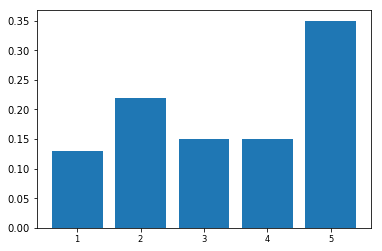

In [202]:
random_result = gen_score(best_playlist)
def energy1(result):
    return 10000*(1.0-(np.array([0,0,0,0.25,0.75])*result).sum())
print("Resulting loss: ", energy1(random_result))
print("Random sampling (1000 samples without replacement, optimized on weighted average between class 4 and 5) class probabilties: ",random_result)
plt.bar(range(len(random_result)), random_result)
plt.xticks(range(len(random_result)), [1,2,3,4,5], size='small')
locs, labels = plt.xticks()
plt.show()

## 3. Simulated annealing

In [203]:
import simanneal
from __future__ import print_function
import math
import random
from simanneal import Annealer

In [204]:
class TravellingSalesmanProblem(Annealer):

    """Test annealer with a travelling salesman problem.
    """
    
    # pass extra data (the distance matrix) into the constructor
    def __init__(self, candidate_songs):
        #self.state = np.array(['2LBkiUn4HmZQN1iV4Q09cn', '3Y10xQQJVB1yjwFQ0ItrY6'])
        state = np.random.choice(candidate_songs,size=10,replace=False)
        self.starting = state
        self.candidate_songs = np.setdiff1d(candidate_songs,state)
        state=list(state)
        #self.features = features
        super(TravellingSalesmanProblem, self).__init__(state)  # important! 

    def move(self):
        """Swaps two cities in the route."""
        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.candidate_songs) - 1)
        #b = random.randint(0, len(self.state) - 1)
        #self.state[a], self.state[b] = self.state[b], self.state[a]
        #print(self.state[a],self.candidate_songs[b])
        reject = self.state[a]
        self.state[a] = self.candidate_songs[b]
        self.candidate_songs[b] = reject
        #print(self.state[a],self.candidate_songs[b])
        
    def energy(self): ## calculates the predicted number of followers
        """Calculates the predicted number of followers."""
        #print(self.state)
        result = gen_score(self.state)
        #print("Calculating energy: ", result)
        #return 1000*(1-(0.67*result[4] + 0.33*result[3]))
        return 10000*(1.0-(np.array([0,0,0,0.25,0.75])*result).sum())

### Tune the energy function for simulated annealing. 
#### We want ~40-60% initial chance of acceptance for a significant decrease in energy

In [205]:
def energy1(result):
    return 10000*(1.0-(np.array([0,0,0,0.25,0.75])*result).sum())

prevEnergy=energy1([ 0.23,  0.25,  0.19,  0.23,  0.1])
E = energy1([ 0.23,  0.25,  0.19,  0.23,  0.04])
# We want this kind of decrease in energy to be associated with something like 70% chance acceptance at first
dE = E - prevEnergy
T = 680
math.exp(-dE / T)

0.51594004821404

### Tune Simulated annealing

In [218]:
def tuneSimAnneal(candidates):
    tsp = TravellingSalesmanProblem(candidates)
    tsp.copy_strategy = "slice"  
    auto_schedule = tsp.auto(minutes=1.5, steps=30)
    auto_schedule['updates'] = auto_schedule['steps']/10
    return auto_schedule

In [219]:
schedules = []
for index, bucket in  enumerate([bucket1,bucket2,bucket3]):
    schedules.append(tuneSimAnneal(bucket))
    print("Bucket #", index+1," parameters: ", schedules[index])

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    15.00000       5925.00     6.67%     0.00%     0:00:54     1:18:27 Temperature        Energy    Accept   Improve     Elapsed   Remaining



Bucket # 1  parameters:  {u'steps': 950.0, u'tmax': 3200.0, u'tmin': 15.0, 'updates': 95.0}


     4.50000       7650.00     0.00%     0.00%     0:01:15     1:08:16 Temperature        Energy    Accept   Improve     Elapsed   Remaining



Bucket # 2  parameters:  {u'steps': 1100.0, u'tmax': 6800.0, u'tmin': 4.5, 'updates': 110.0}


    22.00000       8150.00    10.00%     0.00%     0:00:50     1:08:03


Bucket # 3  parameters:  {u'steps': 1100.0, u'tmax': 2000.0, u'tmin': 22.0, 'updates': 110.0}


### Run Simulated Annealing

In [245]:
def runSimulatedAnnealing(candidates, schedule=auto_schedule, num_runs=1):
    
    # Run sim anneal
    tsp = TravellingSalesmanProblem(candidates)
    tsp.set_schedule(schedule)
    state, e = tsp.anneal()
    resulting_playlist_sim_anneal = state
    start = gen_score(tsp.starting)
    print(schedule)
    
    # Visualize starting point
    print("Starting class probabilties: ",start)
    print(energy1(start))
    plt.bar(range(len(start)), start)
    plt.xticks(range(len(start)), [1,2,3,4,5], size='small')
    locs, labels = plt.xticks()
    plt.show()
    end = gen_score(resulting_playlist_sim_anneal)
    
    # Visualize ending point
    print("Ending class probabilties: ",end )
    print(energy1(end))
    plt.bar(range(len(end)), end)
    plt.xticks(range(len(end)), [1,2,3,4,5], size='small')
    locs, labels = plt.xticks()
    plt.show()
    
    return resulting_playlist_sim_anneal


### Bucket 1 results: Top tracks from related artists

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    15.00000       5300.00     0.00%     0.00%     0:01:28     0:00:00


{u'steps': 950.0, u'tmax': 3200.0, u'tmin': 15.0, 'updates': 95.0}
Starting class probabilties:  [ 0.26  0.17  0.23  0.14  0.2 ]
8150.0


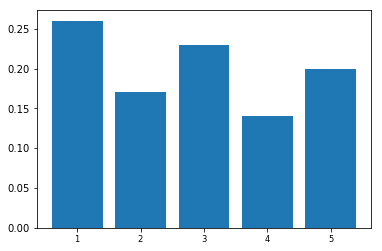

Ending class probabilties:  [ 0.12  0.11  0.11  0.05  0.61]
5300.0


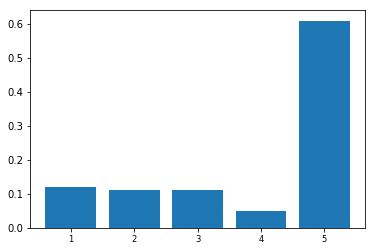

In [227]:
#if __name__ == '__main__':
runSimulatedAnnealing(bucket1, schedules[0], num_runs=1)

### Bucket 2 results: Any tracks from related artists

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     4.50000       6675.00     0.00%     0.00%     0:01:58     0:00:00


{u'steps': 1100.0, u'tmax': 6800.0, u'tmin': 4.5, 'updates': 110.0}
Starting class probabilties:  [ 0.23  0.2   0.29  0.21  0.07]
8950.0


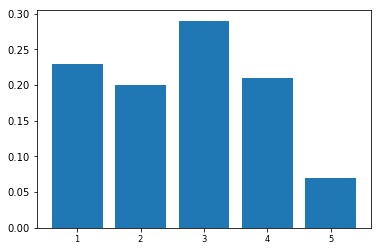

Ending class probabilties:  [ 0.17  0.14  0.16  0.13  0.4 ]
6675.0


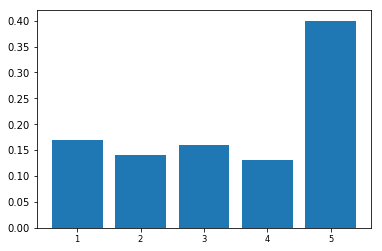

In [228]:
runSimulatedAnnealing(bucket2, schedules[1], num_runs=1)

### Bucket 3 results: Similar tracks from related artists (manhattan distance + spotify API features)

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   164.01864       8550.00    80.00%    50.00%     0:01:06     0:00:53


{u'steps': 1100.0, u'tmax': 2000.0, u'tmin': 22.0, 'updates': 110.0}
Starting class probabilties:  [ 0.36  0.22  0.26  0.14  0.02]
9500.0


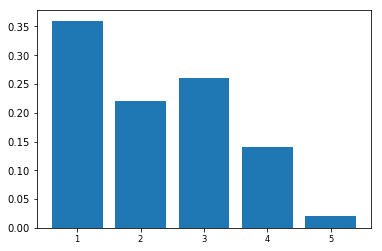

Ending class probabilties:  [ 0.27  0.16  0.18  0.2   0.19]
8075.0


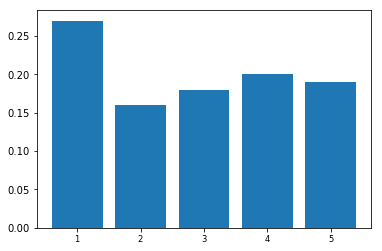

[u'1F7adu7y0bPeBZ2cL4Kn4x',
 u'5ssFH3wCVuy5WIyI51mZYp',
 u'4PdFJXY17UVbB7juOEiKSC',
 u'71MEFMeMFgELWkgmsPVeN5',
 u'3X1v3zH2qzOsstuzaE1iPD',
 u'2ZdNRjGJYeq069uWQ5fXl5',
 u'11EHrEzLMNlhxe7jgi1l7t',
 u'0j5sEwTkXDBQOeS5aKsX85',
 u'7qiZfU4dY1lWllzX7mPBI3',
 u'2QDf6mnHb0psGcXU2UO9Mp']

In [246]:
runSimulatedAnnealing(bucket3, schedules[2], num_runs=1)

In [216]:
# This got good results for all buckets
auto_schedule

{u'steps': 990.0, u'tmax': 1300.0, u'tmin': 4.5, 'updates': 99.0}

### Alternatively, mix buckets together (e.g. take 60% similar songs, 40% top tracks)

In [247]:
def mixBuckets(bucket_one, bucket_two, bucket_two_ratio):
    n_sample_bucket_two = len(bucket_one)*bucket_two_ratio/(1-bucket_two_ratio)
    sample_bucket_two = np.random.choice(bucket_two, replace=False,size= n_sample_bucket_two)
    mixed_bucket = np.concatenate((bucket_one, bucket_two))
    return np.unique(mixed_bucket)

In [248]:
mixed_bucket = mixBuckets(bucket1,bucket3,0.6)

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [249]:
schedule_mixed = tuneSimAnneal(mixed_bucket)

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    13.00000       6475.00     0.00%     0.00%     0:00:58     1:11:49

/Users/lw20302/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:299: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    13.00000       6350.00     0.00%     0.00%     0:01:27     0:00:00


{u'steps': 1000.0, u'tmax': 2700.0, u'tmin': 13.0, 'updates': 100.0}
Starting class probabilties:  [ 0.37  0.22  0.23  0.09  0.09]
9100.0


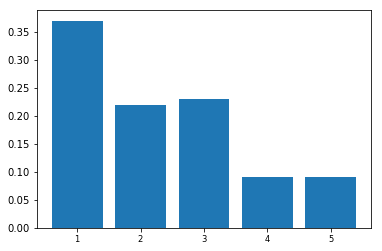

Ending class probabilties:  [ 0.15  0.13  0.14  0.14  0.44]
6350.0


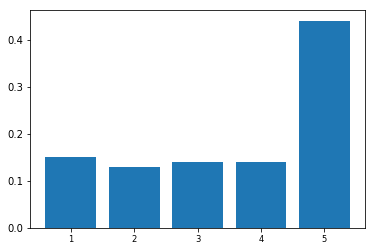

In [250]:
resulting_mixed = runSimulatedAnnealing(mixed_bucket, schedule_mixed)

### Resulting playlist!

In [259]:
from IPython.core.display import display, HTML

for each in resulting_mixed:
    song_id = related_all_features_with_seed[related_all_features_with_seed['id']==each]['id'].values[0]
    link='<a href=' + related_all_features_with_seed[related_all_features_with_seed['id']==each]['preview_url'].values[0] + '>preview related song</a>'
    print(related_all_features_with_seed[related_all_features_with_seed['id']==each]['artists'].values[0])
    link = "<iframe src=\"https://open.spotify.com/embed?uri=spotify:track:" + song_id + "\"frameborder=\"0\" allowtransparency=\"true\"></iframe>"
    #print(link)
    display(HTML(link))


Ellie Goulding


One Direction


Olly Murs


Olly Murs


James Blunt


James Bay


ZAYN


Birdy


Clean Bandit


Sam Smith


### Appendix: Travelling Salesman Example for Simulated Annealing 

In [279]:
from __future__ import print_function
import math
import random
from simanneal import Annealer


def distance(a, b):
    """Calculates distance between two latitude-longitude coordinates."""
    R = 3963  # radius of Earth (miles)
    lat1, lon1 = math.radians(a[0]), math.radians(a[1])
    lat2, lon2 = math.radians(b[0]), math.radians(b[1])
    return math.acos(math.sin(lat1) * math.sin(lat2) +
                     math.cos(lat1) * math.cos(lat2) * math.cos(lon1 - lon2)) * R


class TravellingSalesmanProblem(Annealer):

    """Test annealer with a travelling salesman problem.
    """
    
    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important! 

    def move(self):
        """Swaps two cities in the route."""
        a = random.randint(0, len(self.state) - 1)
        b = random.randint(0, len(self.state) - 1)
        self.state[a], self.state[b] = self.state[b], self.state[a]

    def energy(self):
        """Calculates the length of the route."""
        e = 0
        for i in range(len(self.state)):
            e += self.distance_matrix[self.state[i-1]][self.state[i]]
        return e



if __name__ == '__main__':

    # latitude and longitude for the twenty largest U.S. cities
    cities = {
        'New York City': (40.72, 74.00),
        'Los Angeles': (34.05, 118.25),
        'Chicago': (41.88, 87.63),
        'Houston': (29.77, 95.38),
        'Phoenix': (33.45, 112.07),
        'Philadelphia': (39.95, 75.17),
        'San Antonio': (29.53, 98.47),
        'Dallas': (32.78, 96.80),
        'San Diego': (32.78, 117.15),
        'San Jose': (37.30, 121.87),
        'Detroit': (42.33, 83.05),
        'San Francisco': (37.78, 122.42),
        'Jacksonville': (30.32, 81.70),
        'Indianapolis': (39.78, 86.15),
        'Austin': (30.27, 97.77),
        'Columbus': (39.98, 82.98),
        'Fort Worth': (32.75, 97.33),
        'Charlotte': (35.23, 80.85),
        'Memphis': (35.12, 89.97),
        'Baltimore': (39.28, 76.62)
    }

    # initial state, a randomly-ordered itinerary
    init_state = list(cities.keys())
    random.shuffle(init_state)

    # create a distance matrix
    distance_matrix = {}
    for ka, va in cities.items():
        distance_matrix[ka] = {}
        for kb, vb in cities.items():
            if kb == ka:
                distance_matrix[ka][kb] = 0.0
            else:
                distance_matrix[ka][kb] = distance(va, vb)

    tsp = TravellingSalesmanProblem(init_state, distance_matrix)
    # since our state is just a list, slice is the fastest way to copy
    tsp.copy_strategy = "slice"  
    state, e = tsp.anneal()

    while state[0] != 'New York City':
        state = state[1:] + state[:1]  # rotate NYC to start
    print("%i mile route:" % e)
    for city in state:
        print("\t", city)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000       6883.00     5.20%     0.00%     0:00:01     0:00:00


6845 mile route:
	 New York City
	 Philadelphia
	 Baltimore
	 Charlotte
	 Jacksonville
	 Houston
	 Austin
	 San Antonio
	 Phoenix
	 San Diego
	 Los Angeles
	 San Jose
	 San Francisco
	 Fort Worth
	 Dallas
	 Memphis
	 Indianapolis
	 Chicago
	 Detroit
	 Columbus
